# Active Learning With Allaart's Classifier & Data Set
### For research paper: Active Learning To Reduce Human Labeling For Automatic Psychological TextClassification
### Author: Jahson O'Dwyer Wha Binda

# Import DataSet

In [44]:
import csv

with open('FINAL_CSV.csv') as data:
    reader = csv.DictReader(data)

# Data
    story = []
    labels = ["Vulnerable", "Angry", "Impulsive", "Happy", "Detached", "Punishing", "Healthy"]
# Labels
    is_vulnerable = []
    is_angry = []
    is_impulsive = []
    is_happy = []
    is_detached = []
    is_punishing = []
    is_healthy = []
    
#  Load DATA/Labels
    for row in reader:
        story.append(row['Text'])
        is_vulnerable.append(row['is_vulnerable'] == 'TRUE')
        is_angry.append(row['is_angry'] == 'TRUE')
        is_impulsive.append(row['is_impulsive'] == 'TRUE')
        is_happy.append(row['is_happy'] == 'TRUE')
        is_detached.append(row['is_detached'] == 'TRUE')
        is_punishing.append(row['is_punishing'] == 'TRUE')
        is_healthy.append(row['is_healthy'] == 'TRUE')

# Normal SVN PreProccessing
## Data 

In [45]:
import numpy as np
import sklearn as skl
from sklearn.model_selection import train_test_split

print(np.__version__)
print(skl.__version__)

randomSeed = 37
trainSize = 0.80


#Combine All Labels (Schema)
schema = np.vstack((is_vulnerable, is_angry, is_impulsive, is_happy, is_detached, is_punishing, is_healthy)).T

# Split into training and testing data
story_train, story_test, schema_train, schema_test = train_test_split(story, schema, train_size=trainSize, random_state=randomSeed)
print(schema_train)

1.19.5
0.24.2
[[ True False False ... False False  True]
 [False False False ... False False  True]
 [False  True False ... False False  True]
 ...
 [ True  True False ... False False  True]
 [ True  True False ...  True False  True]
 [False  True False ... False False  True]]


In [46]:
#Natural Language PreProcessing
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


#Tokenization
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(story_train)
word_index = tokenizer.word_index

sequences_train = tokenizer.texts_to_sequences(story_train)
story_padded_train = pad_sequences(sequences_train, padding="post", maxlen=617)

sequences_test = tokenizer.texts_to_sequences(story_test)
story_padded_test = pad_sequences(sequences_test, padding="post", maxlen=617)

#Convert to Numpy Array
story_padded_train = np.array(story_padded_train)
story_padded_test = np.array(story_padded_test)
schema_train = np.array(schema_train)
schema_test = np.array(schema_test)

In [47]:
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.svm import LinearSVR
from sklearn.svm import NuSVC
from sklearn.svm import NuSVR
from sklearn.svm import OneClassSVM
from sklearn.svm import SVR
from sklearn.svm import l1_min_c


from sklearn.calibration import CalibratedClassifierCV

from sklearn.multioutput import MultiOutputClassifier

# Create the SVM
svm = SVC(random_state=randomSeed, probability=True)

# Active Learning:


In [48]:
from sklearn.metrics import accuracy_score

from modAL.models import ActiveLearner
from modAL.multilabel import SVM_binary_minimum
from modAL.multilabel import min_confidence



initX= story_padded_train[:8]
initY= schema_train[:8]
story_padded_train = story_padded_train[8:]
schema_train = schema_train[8:]
print(initY)

learner = ActiveLearner(
    estimator=MultiOutputClassifier(svm, n_jobs=-1),
    query_strategy=min_confidence,
    X_training=initX, y_training=initY
)


pred = learner.predict(story_padded_test)
unqueried_score = accuracy_score(y_true=schema_test, y_pred=pred)
print("{:.2%}".format(unqueried_score))

[[ True False False False False False  True]
 [False False False  True False False  True]
 [False  True False  True False False  True]
 [False False False  True False False  True]
 [False False False False False False  True]
 [False False False  True False False  True]
 [ True False  True  True  True  True False]
 [False  True False  True  True False  True]]
34.91%


In [49]:
from sklearn.utils import check_consistent_length

N_QUERIES = 30
performance_history = [unqueried_score]
schema_history = []

for i in range(7):
    schema_history.append([accuracy_score(y_true=schema_test[:,i], y_pred=pred[:,i])])

# Allow our model to query our unlabeled dataset for the most
# informative points according to our query strategy.
for index in range(N_QUERIES):
    query_index, query_instance = learner.query(story_padded_train)
    
    query_index = query_index[0][0]
    
    # Teach our ActiveLearner model the record it has requested.
    X, y = story_padded_train[query_index].reshape(1, -1), schema_train[query_index].reshape(1, -1)
    
    learner.teach(X=X, y=y)
    
    # Remove the queried instance from the unlabeled pool.
    story_padded_train, schema_train = np.delete(story_padded_train, query_index, axis=0), np.delete(schema_train, query_index, axis=0)
    
    # Calculate and report our model's accuracy.
    qPred = learner.predict(story_padded_test)
    model_accuracy = accuracy_score(y_true=schema_test, y_pred=qPred)
    print('Accuracy after query {n}: {acc:0.4f}'.format(n=index + 1, acc=model_accuracy))
    
    # Save our model's performance for plotting.
    performance_history.append(model_accuracy)
    for i in range(7):
        schema_history[i].append(accuracy_score(y_true=schema_test[:,i], y_pred=qPred[:,i]))

Accuracy after query 1: 0.3491
Accuracy after query 2: 0.3491
Accuracy after query 3: 0.3491
Accuracy after query 4: 0.3491
Accuracy after query 5: 0.3491
Accuracy after query 6: 0.3491
Accuracy after query 7: 0.3491
Accuracy after query 8: 0.3491
Accuracy after query 9: 0.3491
Accuracy after query 10: 0.3491
Accuracy after query 11: 0.3491
Accuracy after query 12: 0.3491
Accuracy after query 13: 0.3491
Accuracy after query 14: 0.3491
Accuracy after query 15: 0.3491
Accuracy after query 16: 0.3491
Accuracy after query 17: 0.3491
Accuracy after query 18: 0.3491
Accuracy after query 19: 0.3491
Accuracy after query 20: 0.3491
Accuracy after query 21: 0.3491
Accuracy after query 22: 0.3491
Accuracy after query 23: 0.3491
Accuracy after query 24: 0.3491
Accuracy after query 25: 0.3491
Accuracy after query 26: 0.3491
Accuracy after query 27: 0.3491
Accuracy after query 28: 0.3491
Accuracy after query 29: 0.3491
Accuracy after query 30: 0.3491


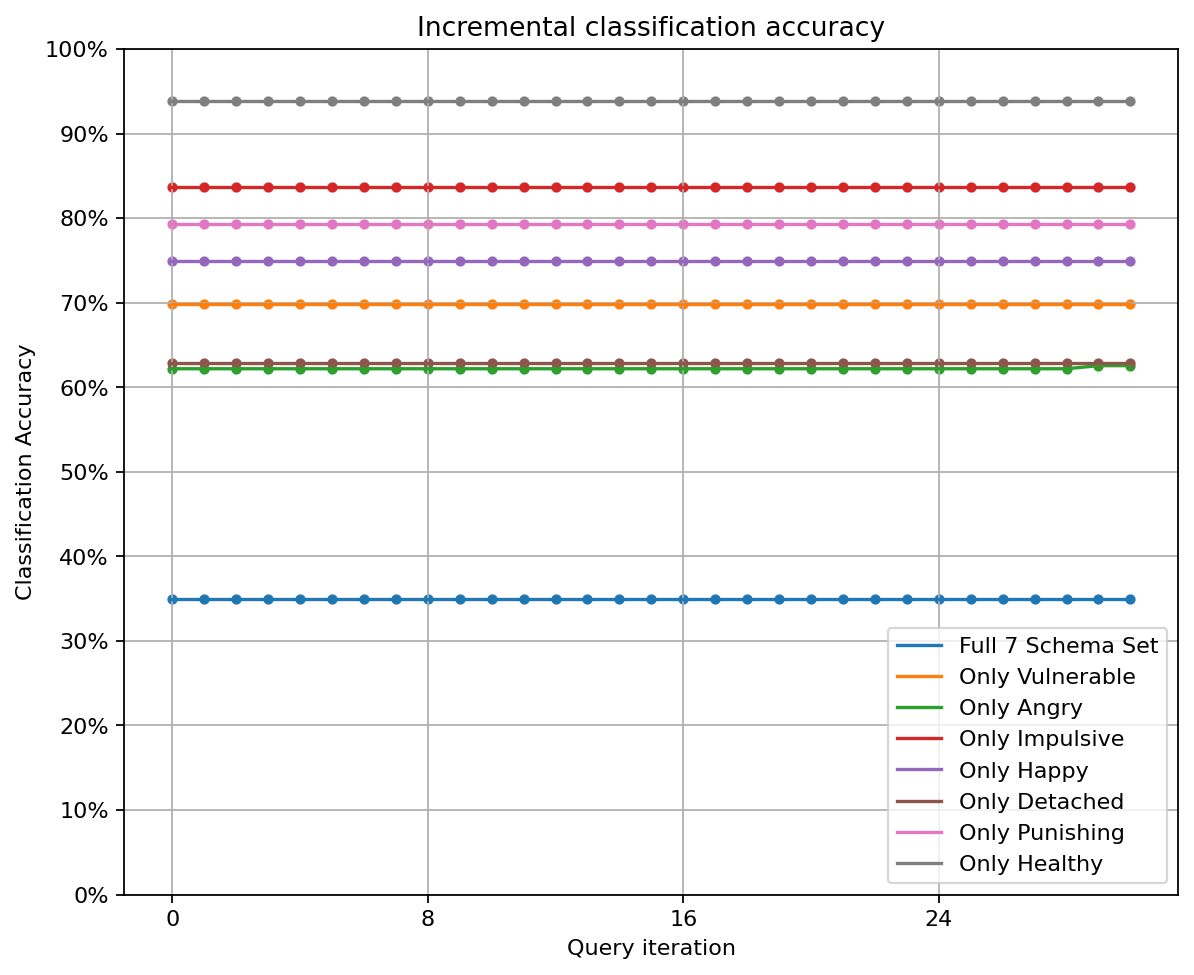

In [50]:
import matplotlib as mpl
import matplotlib.pyplot as plt
# Plot our performance over time.
fig, ax = plt.subplots(figsize=(8.5, 7), dpi=160)

ax.plot(performance_history, label="Full 7 Schema Set")
ax.scatter(range(len(performance_history)), performance_history, s=13)
for i in range(7):
    ax.plot(schema_history[i], label="Only "+ labels[i])
    ax.scatter(range(len(schema_history[i])), schema_history[i], s=13)

ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

ax.set_ylim(bottom=0, top=1)
ax.grid(True)

ax.set_title('Incremental classification accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')

plt.legend(loc="lower right")
plt.show()

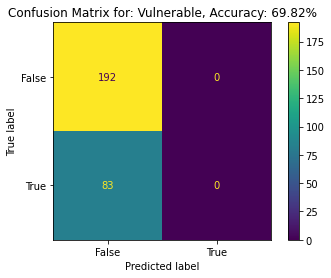

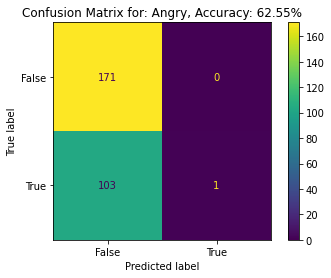

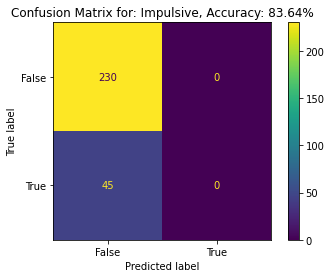

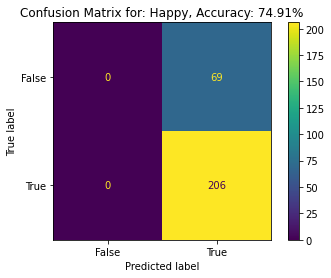

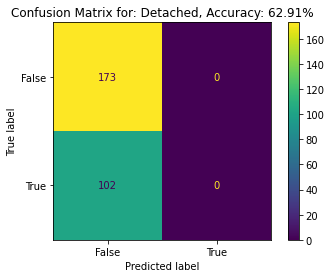

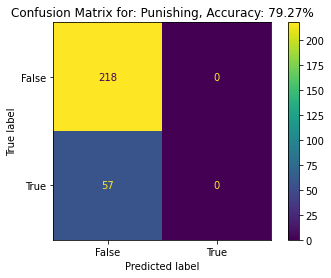

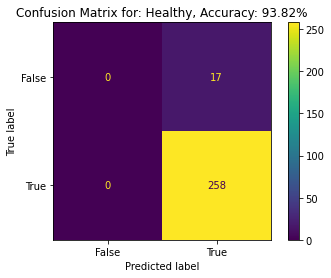

In [52]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score, ConfusionMatrixDisplay, f1_score, classification_report, plot_roc_curve, roc_curve, auc
x_test=story_padded_test
y_test = schema_test
preds= learner.predict(x_test)

# Generate multiclass confusion matrices
matrices = multilabel_confusion_matrix(y_test, preds)
# Plotting matrices: code
i = 1
for mat in matrices:
    cmd = ConfusionMatrixDisplay(mat, display_labels=np.unique(y_test)).plot()
    accuracy_calc = accuracy_score(y_true=y_test[:,i-1], y_pred=preds[:,i-1])
    plt.title('Confusion Matrix for: ' + str(labels[i-1]) + ", Accuracy: " + "{:.2%}".format(accuracy_calc))
    plt.show()
    i += 1